In [1]:
### Import libraries

%matplotlib inline
import xarray as xr
import cmocean as cmo
import pandas as pd
from glob import glob

import numpy as np
import numpy.ma as ma

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import matplotlib.path as mpath
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib.ticker as mticker
from matplotlib.colors import BoundaryNorm
from matplotlib.lines import Line2D

import cartopy
import cartopy.crs as ccrs

from cycler import cycler

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

warnings.filterwarnings("ignore", message="All-NaN slice encountered", category=RuntimeWarning)

# General settings and preparation

In [2]:
### Define functions for preparation of data and plotting

def divide_longitude(lons, lats, var):
    '''
    Split data into sections east and west of the prime meridian.
    
    Parameters:
    ---
    lons (array): longitudes
    lats (array): latitudes
    var (array): variable data associated with the latitudes and longitudes
        
    Returns:
    ---
    lons_greater (array): longitudes east of the prime meridian (0 to 180°)
    lons_lesser (array): longitudes west of the prime meridian (-180 to 0°)
    lats_greater (array): latitudes corresponding to lons_greater
    lats_lesser (array): latitudes corresponding to lons_lesser
    var_greater (array): variable data corresponding to lons_greater
    var_lesser (array): variable data corresponding to lons_lesser
    '''
    
    # Mask based on longitudes
    lons_greater = ma.masked_greater(lons, -0.01)
    lons_lesser = ma.masked_less(lons, 0.)
    
    lats_greater = ma.MaskedArray(lats, mask=lons_greater.mask)
    lats_lesser = ma.MaskedArray(lats, mask=lons_lesser.mask)
    
    var_greater = ma.MaskedArray(var, mask=lons_greater.mask)
    var_lesser = ma.MaskedArray(var, mask=lons_lesser.mask)
    
    return lons_greater, lons_lesser, lats_greater, lats_lesser, var_greater, var_lesser



def mask_land(lons, lats, bathy, var):
    '''
    Mask land areas (elevation above zero)
    
    Parameters:
    ---
    lons (array): longitudes
    lats (array): latitudes
    bathy (array): bathymetry
    var (array): variable data associated with the latitudes and longitudes
        
    Returns:
    ---
    lons_land (array): longitudes corresponding to ocean
    lats_land (array): latitudes corresponding to ocean
    var_land (array): variable data corresponding to ocean
    '''
    
    # Mask land based on bathymetry
    bathy_land = ma.masked_greater(bathy, 0.)
    lons_land = ma.MaskedArray(lons, mask=bathy_land.mask)
    lats_land = ma.MaskedArray(lats, mask=bathy_land.mask)
    var_land = ma.MaskedArray(var, mask=bathy_land.mask)
    
    return lons_land, lats_land, var_land



def filter_trajectories(dataset, remove_indices):
    '''
    Filter trajectories in the dataset based on remove_indices.

    Parameters:
    ---
    dataset (dataset): dataset of trajectories
    remove_indices (array): indices to be removed from trajectories

    Returns:
    ---
    filtered_dataset (dataset): dataset with filtered trajectories
    '''
    mask = ~dataset['trajectory'].isin(remove_indices)
    
    return dataset.sel(trajectory=mask)



def prepare_outline_trajectory_plot(ax):
    '''
    Prepare map (boundaries, coastlines, gridlines) for plotting iceberg trajectories.
    
    Parameters:
    ---
    ax : matplotlib axes object
        
    Returns:
    ---
    ax : modified matplotlib axes object with extent and boundary, coastlines, and gridlines
    '''
    
    # Set extent and boundary
    ax.set_extent([-50, 35, -90, -50], ccrs.PlateCarree())
    
    ylim = [-90,-50]
    xlim = [-90,90]
    rect = mpath.Path([[xlim[0], ylim[0]],
                       [xlim[1], ylim[0]],
                       [xlim[1], ylim[1]],
                       [xlim[0], ylim[1]],
                       [xlim[0], ylim[0]],
                       ]).interpolated(40)
    proj_to_data   = ccrs.PlateCarree()._as_mpl_transform(ax) - ax.transData
    rect_in_target = proj_to_data.transform_path(rect)
    ax.set_boundary(rect_in_target)
    
    # Coastline
    ax.contour(lons[:760,850:2700], lats[:760,850:2700], bath[:760,850:2700], levels=[0], transform=ccrs.PlateCarree(), colors='k', zorder=2)
    ax.scatter(1, -78.3, transform=ccrs.PlateCarree(), color='white', zorder=4, s=14)
    
    # Gridlines
    gl_configurations = [([-60, -30, 0, 30, 60], []),   # -60, -30, 0, 30, 60 W/E
                         ([], np.arange(-90,-59,10)),   # 90, 80, 70, 60 S
                         ([], np.arange(-50,-49,10))]   # 50 S
    
    for i in range(3):
        gl = ax.gridlines(linestyle='--' if i < 2 else '-', linewidth=.7 if i < 2 else 1,
                          draw_labels=False, x_inline=False, y_inline=False,
                          crs=ccrs.PlateCarree(), zorder=5)
        
        gl.xlocator = mticker.FixedLocator(gl_configurations[i][0])
        gl.ylocator = mticker.FixedLocator(gl_configurations[i][1])
    
    return ax



def prepare_outline_ODP_plot(ax):
    '''
    Prepare map (boundaries, coastlines, gridlines) for detailed plotting around ODP Site 696.
    
    Parameters:
    ---
    ax : matplotlib axes object
        
    Returns:
    ---
    ax : modified matplotlib axes object with extent, coastlines, and gridlines
    '''
    
    # Set extent
    ax.set_extent([-60, -30, -78, -60], ccrs.PlateCarree())
    
    # Coastline
    ax.contour(lons[:760,850:2700], lats[:760,850:2700], bath[:760,850:2700], levels=[0], transform=ccrs.PlateCarree(), colors='k', zorder=2)
    ax.scatter(1, -78.3, transform=ccrs.PlateCarree(), color='white', zorder=4, s=14)
    
    # Gridlines
    gl_configurations = [([-60], []),                   # 60W
                         ([-30], []),                   # 30 W
                         ([], np.arange(-80,-69,10)),   # 80, 70 S
                         ([], np.arange(-60,-59,10))]   # 60 S
    
    for i in range(3):
        gl = ax.gridlines(linestyle='--', linewidth=.7,
                          draw_labels=True, x_inline=False, y_inline=False,
                          crs=ccrs.PlateCarree(), zorder=5)
        
        gl.xlocator = mticker.FixedLocator(gl_configurations[i][0])
        gl.ylocator = mticker.FixedLocator(gl_configurations[i][1])
        
        # Position labels
        if i == 0:     # left side
            gl.right_labels  = False
            gl.bottom_labels = False
            gl.left_labels   = True
            gl.top_labels    = False
        elif i==1:     # top
            gl.right_labels  = False
            gl.bottom_labels = False
            gl.left_labels   = False
            gl.top_labels    = True
            gl.rotate_labels = False
        elif i == 2:   # right side
            gl.right_labels  = True
            gl.bottom_labels = False
            gl.left_labels   = False
            gl.top_labels    = False
            gl.rotate_labels = False
        else:         # line
            gl.right_labels  = False
            gl.bottom_labels = False
            gl.left_labels   = False
            gl.top_labels    = False
            
        gl.xlabel_style = {'size': 12}
        gl.ylabel_style = {'size': 12}
    
    return ax



def prepare_outline_SPS_plot(ax):
    '''
    Prepare map (boundaries, coastlines, gridlines) for plotting with South Polar Stereo projection.
    
    Parameters:
    ---
    ax : matplotlib axes object
        
    Returns:
    ---
    ax : modified matplotlib axes object with exent, circular boundary, coastlines, ODP Site 696 and gridlines
    '''
    
    # Set extent and boundary
    ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
    ax.set_boundary(circle, transform=ax.transAxes)
    
    # Coastline
    ax.contour(lons[:760,:], lats[:760,:], bath[:760,:], levels=[0], transform=ccrs.PlateCarree(), colors='k', zorder=3)
    
    # ODP Site 696
    ax.plot(x696_le, y696_le, color='r', marker='*', markersize=10, markeredgecolor='black', markeredgewidth=.5,
            transform=ccrs.PlateCarree(), zorder=2)
    
    # Gridlines
    ax.gridlines(linestyle='--')
    
    return ax

In [3]:
### Settings circular boundary South Polar Stereo projection plot
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [4]:
### Base path to files
base_path = '/nethome/5867800/'

In [5]:
### Locations

# ODP Site 696
x696_pd, y696_pd = -42.933067, -61.849083   # present-day coordinates [°]
x696_le, y696_le = -57., -67.5              # late Eocene coordinates (determined visually) [°]

# Gridcell distance
gcd = (np.deg2rad(0.1)*6371e3)              # gridcell distance [m]

# Forwards release locations [°]
lons_fw = np.array([-55., -50., -45., -40., -35.,
                    -30., -25., -20., -15., -10.,
                     -5.,   0.,   5.,  10.,  15.,
                     20.,  25.,  30.,  35.,  40.,
                     45.,  50.,  55.,  60., -57.82330253])
lats_fw = np.array([-77.99537227, -78.45787684, -79.17977465, -79.75459498, -79.99027112,
                    -80.07689735, -79.9997914 , -80.12097168, -79.24559138, -78.39033646,
                    -77.33178711, -76.13251966, -75.17986379, -74.68456009, -73.6896764 ,
                    -73.53134648, -72.9724492 , -72.3117251 , -72.29006817, -72.16268516,
                    -70.86573029, -68.58359528, -68.58359528, -66.59729004, -77.])

In [6]:
### Prepare bathymetric data

# Load data Nooteboom et al. (2022)
topo = xr.open_dataset(base_path + 'grid/adapted_bathymetry.nc')

# Load latitudes, longitudes and bathymetry
lonsg, lonsl, latsg, latsl, varg, varl = divide_longitude(topo.variables['T_LON_2D'][:,:], topo.variables['T_LAT_2D'][:,:], topo.variables['Bathymetry'][:,:])
lons = np.concatenate((lonsg[:,2650:], lonsg[:,:850], lonsl[:,850:2650]), axis=1)   # -179.95 to -85.05, -84.95 to -0.05, 0.05 to 179.95
lats = np.concatenate((latsg[:,2650:], latsg[:,:850], latsl[:,850:2650]), axis=1)
bath = np.concatenate((varg[:,2650:], varg[:,:850], varl[:,850:2650]), axis=1)

# Figures forwards simulations

First, load and prepare the data of the forwards simulations. Note that the simulations were ran initially with four additional release locations along North Graham Land, which were removed later based on the geochronology of the region. 

Start with the main simulations, which consist of depth-integrated simulations for each iceberg size class (C1-C5) including iceberg grounding, and a simulation for iceberg size class C4 using only surface fields.

In [7]:
### Load data of main forwards simulations
C1g = xr.open_zarr(base_path + 'active/29p_5y_int_30d_1hdtar_C1g.zarr')   # grounding, C1 (L=10m)
C2g = xr.open_zarr(base_path + 'active/29p_5y_int_30d_1hdtar_C2g.zarr')   # grounding, C2 (L=100m)
C3g = xr.open_zarr(base_path + 'active/29p_5y_int_30d_1hdtar_C3g.zarr')   # grounding, C3 (L=1000m)
C4g = xr.open_zarr(base_path + 'active/29p_5y_int_30d_1hdtar_C4g.zarr')   # grounding, C4 (L=10000m)
C5g = xr.open_zarr(base_path + 'active/29p_5y_int_30d_1hdtar_C5g.zarr')   # grounding, C5 (L=100000m)
SF  = xr.open_zarr(base_path + 'active/29p_5y_surf_30d_1hdtar_C4.zarr')   # surface w/o grounding, C4 (L=10000m)

In [8]:
### Determine release locations from North Graham Land
remove_NGL = np.sort(np.concatenate((np.arange(25, len(C3g['trajectory']), 29),
                                     np.arange(26, len(C3g['trajectory']), 29),
                                     np.arange(27, len(C3g['trajectory']), 29),
                                     np.arange(28, len(C3g['trajectory']), 29))))

In [9]:
### Remove North Graham Land release locations for each dataset
main_datasets = [C1g, C2g, C3g, C4g, C5g, SF]
filtered_datasets = []

for dataset in main_datasets:
    filtered_dataset = filter_trajectories(dataset, remove_NGL)
    filtered_datasets.append(filtered_dataset)

C1g_filtered, C2g_filtered, C3g_filtered, C4g_filtered, C5g_filtered, SF_filtered = filtered_datasets

The simulations described in the supplementary file consist of a simulation of passive particles at the surface, and depth-integrated simulations including iceberg grounding for icebergs of size class C4 with a southwestward shift in the location of ODP Site 696 and of iceberg size class C5 using the adapted basal melt equation as described in the supplements.

In [10]:
### Load data supplementary forwards simulations
PF   = xr.open_zarr(base_path + 'passive/29p_5y_30d_1hdtar.zarr')          # passive
C4gs = xr.open_zarr(base_path + 'active/29p_5y_int_30d_1hdtar_C4gs.zarr')  # grounding, C4 changed location ODP696 (L=10000m)
C5a  = xr.open_zarr(base_path + 'active/29p_5y_int_30d_1hdtar_C5ga.zarr')  # grounding, C5 adapted basal melt (L=100000m)

In [11]:
### Remove North Graham Land release locations for each dataset
sup_datasets = [PF, C4gs, C5a]
filtered_datasets = []

for dataset in sup_datasets:
    filtered_dataset = filter_trajectories(dataset, remove_NGL)
    filtered_datasets.append(filtered_dataset)

PF_filtered, C4gs_filtered, C5a_filtered = filtered_datasets

## Trajectories

Plot iceberg trajectories from forwards simulations to show the flow pattern of the icebergs and highlight the trajectories that reach ODP Site 696.

Main simulations: Figure 3

| []() | []() | []() |
|------|------|------|
|  C3g |  C4g |  C5g |
|  C4d |  SF  |      |

In [12]:
### Load data
data = [C3g_filtered, C4g_filtered, C5g_filtered,
        C4g_filtered, SF_filtered]
names = ['C3g', 'C4g', 'C5g',
         'C4gd', 'C4s']
labels = ['C3 icebergs', 'C4 icebergs', 'C5 icebergs',
          'C4 icebergs - doubled target radius', 'C4 icebergs - surface only']

In [13]:
### Prepare data
tcoord_dict = {}

for idx, dat in enumerate(data):
    minvals = np.nanmin(dat['distance'], axis=1)               # find minimum distance to ODP Site 696 for each iceberg
    gcd_threshold = gcd if names[idx] != 'C4gd' else 2 * gcd   # set the threshold distance to one or two times the gridcell distance
    mask = minvals <= gcd_threshold                            # select trajectories that reach ODP Site 696 within the gridcell distance

    # Select all coordinates for the trajectories reaching ODP Site 696
    tlat = xr.where(mask[:, np.newaxis], dat['lat'], np.nan)
    tlon = xr.where(mask[:, np.newaxis], dat['lon'], np.nan)
    tcoord_dict[names[idx]] = {'tlat': tlat, 'tlon': tlon}

Start plotting C3g...
   trajectories reaching ODP plotted...
   other trajectories plotted...
Start plotting C4g...
   trajectories reaching ODP plotted...
   other trajectories plotted...
Start plotting C5g...
   trajectories reaching ODP plotted...
   other trajectories plotted...
Start plotting C4gd...
   trajectories reaching ODP plotted...
   other trajectories plotted...
Start plotting C4s...
   trajectories reaching ODP plotted...
   other trajectories plotted...
Saving figure...
Figure saved.


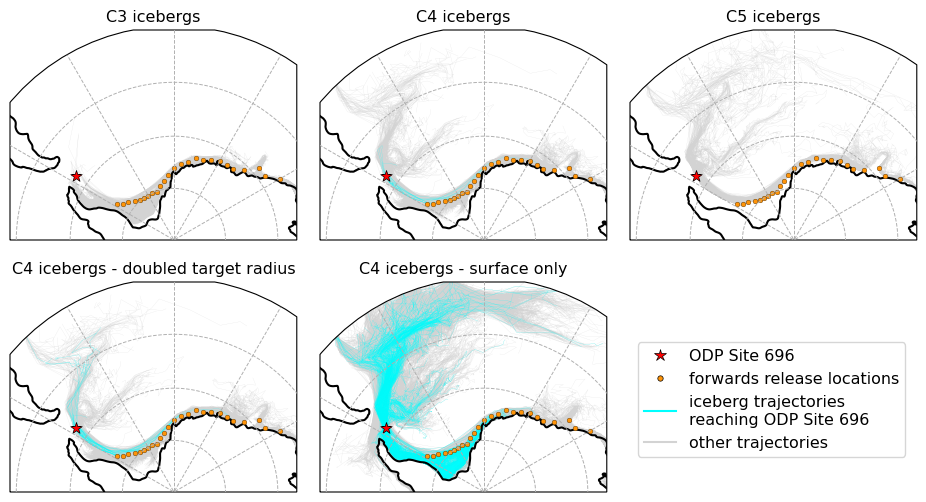

In [14]:
### Plot

# Prepare axes
fig = plt.figure(figsize=(12,6))
gs = GridSpec(2, 1, hspace=0.2, height_ratios=[1,1])                                         # figure: 2 rows, 1 column
gs0 = GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[0], wspace=0., width_ratios=(2, 2, 2))   # split top row: 1 row, 3 columns
gs1 = GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[1], wspace=0., width_ratios=(2, 2, 2))   # split bottom row: 1 row, 3 columns
axes = [fig.add_subplot(g, projection=ccrs.SouthPolarStereo()) for g in (gs0[0,0], gs0[0,1], gs0[0,2], gs1[0,0], gs1[0,1])]

for dat, name, label, ax in zip(data, names, labels, axes):  
    print(f'Start plotting {name}...')

    ax = prepare_outline_trajectory_plot(ax)
    ax.set_title(f'{str(label)}', fontsize=11.5)

    # Plot ODP
    ax.scatter(x696_le, y696_le, transform=ccrs.PlateCarree(), color='r', marker='*', s=75, edgecolor='black', linewidth=.5, zorder=3)

    # Plot trajectories
    ax.plot(tcoord_dict[name]['tlon'].T, tcoord_dict[name]['tlat'].T, transform=ccrs.Geodetic(), linewidth=.1, zorder=1, color='cyan', rasterized=True)
    print(f'   trajectories reaching ODP plotted...')
    ax.plot(dat['lon'].T, dat['lat'].T, transform=ccrs.Geodetic(), linewidth=.1, zorder=0, color='lightgrey', rasterized=True)
    print(f'   other trajectories plotted...')

    # Plot release locations
    ax.scatter(lons_fw, lats_fw, transform=ccrs.PlateCarree(), color='xkcd:tangerine', s=12, edgecolor='k', linewidths=.2, zorder=3)
    
    if name == 'C4s':
        handles, labels = ax.get_legend_handles_labels()
        ODP = Line2D([0], [0], label='ODP Site 696', marker='*', markersize=np.sqrt(75),
                     markeredgecolor='k', markerfacecolor='r', markeredgewidth=.5, linestyle='')
        handles.append(ODP)
        rel = Line2D([0], [0], label='forwards release locations', marker='o', markersize=np.sqrt(15),
                     markeredgecolor='k', markerfacecolor='xkcd:tangerine', markeredgewidth=.5, linestyle='')
        handles.append(rel)
        suc = Line2D([0], [0], label='iceberg trajectories \nreaching ODP Site 696', color='cyan')
        handles.append(suc)
        oth = Line2D([0], [0], label='other trajectories', color='lightgrey')
        handles.append(oth)
        ax.legend(handles=handles, bbox_to_anchor=(1.08, .75), fontsize='11.5')

print('Saving figure...')
plt.savefig(f'figures/Paper/F03FWTrajectories.pdf', bbox_inches='tight', dpi=300)
print(f'Figure saved.')
plt.show()

Supplement: Figure S3.1

| []() | []() | []() |
|------|------|------|
|  PF  | C4gs | C5ga |

In [15]:
### Load data
data_sup = [PF_filtered, C4gs_filtered, C5a_filtered]
names_sup = ['PF', 'C4gs', 'C5a']
labels_sup = ['Passive particles', 'C4 icebergs - shifted position', 'C5 icebergs - adapted basal melt']

In [16]:
### Prepare data
tcoord_dict = {}

for idx, dat in enumerate(data_sup):
    minvals = np.nanmin(dat['distance'], axis=1)   # find minimum distance to ODP Site 696 for each iceberg
    gcd_threshold = gcd                            # set the threshold distance to one or two times the gridcell distance
    mask = minvals <= gcd_threshold                 # select trajectories that reach ODP Site 696 within the gridcell distance

    # Select all coordinates for the trajectories reaching ODP Site 696
    tlat = xr.where(mask[:, np.newaxis], dat['lat'], np.nan)
    tlon = xr.where(mask[:, np.newaxis], dat['lon'], np.nan)
    tcoord_dict[names_sup[idx]] = {'tlat': tlat, 'tlon': tlon}

Start plotting PF...
   trajectories reaching ODP plotted...
   other trajectories plotted...
Start plotting C4gs...
   trajectories reaching ODP plotted...
   other trajectories plotted...
Start plotting C5a...
   trajectories reaching ODP plotted...
   other trajectories plotted...
Saving figure...
Figure saved.


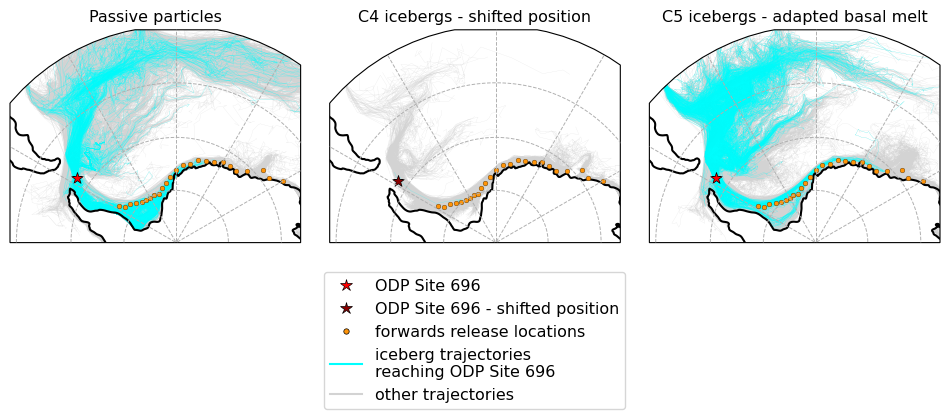

In [17]:
fig = plt.figure(figsize=(12,3))

gs = GridSpec(1, 1)                                                                           # figure: 1 row, 1 column
gs0 = GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[0], wspace=0.1, width_ratios=(2, 2, 2))   # split top row: 1 row, 3 columns

axes = [fig.add_subplot(g, projection=ccrs.SouthPolarStereo()) for g in (gs0[0,0], gs0[0,1], gs0[0,2])]

for dat, name, label, ax in zip(data_sup, names_sup, labels_sup, axes):
    print(f'Start plotting {name}...')

    ax = prepare_outline_trajectory_plot(ax)
    ax.set_title(f'{str(label)}', fontsize=11.5)

    # Plot ODP
    if name == 'C4gs':
        ax.scatter(x696_le-1, y696_le-0.5, transform=ccrs.PlateCarree(), color='darkred', marker='*', s=75, edgecolor='black', linewidth=.5, zorder=3)
    else:
        ax.scatter(x696_le, y696_le, transform=ccrs.PlateCarree(), color='r', marker='*', s=75, edgecolor='black', linewidth=.5, zorder=3)

    # Plot trajectories
    ax.plot(tcoord_dict[name]['tlon'].T, tcoord_dict[name]['tlat'].T, transform=ccrs.Geodetic(), linewidth=.1, zorder=1, color='cyan', rasterized=True)
    print(f'   trajectories reaching ODP plotted...')
    ax.plot(dat['lon'].T, dat['lat'].T, transform=ccrs.Geodetic(), linewidth=.1, zorder=0, color='lightgrey', rasterized=True)
    print(f'   other trajectories plotted...')

    # Plot release locations
    ax.scatter(lons_fw, lats_fw, transform=ccrs.PlateCarree(), color='xkcd:tangerine', s=12, edgecolor='k', linewidths=.2, zorder=3)
    
    if name == 'C4gs':
        handles, labels = ax.get_legend_handles_labels()
        ODP = Line2D([0], [0], label='ODP Site 696', marker='*', markersize=np.sqrt(75),
                     markeredgecolor='k', markerfacecolor='r', markeredgewidth=.5, linestyle='')
        handles.append(ODP)
        ODPs = Line2D([0], [0], label='ODP Site 696 - shifted position', marker='*', markersize=np.sqrt(75),
                     markeredgecolor='k', markerfacecolor='darkred', markeredgewidth=.5, linestyle='')
        handles.append(ODPs)
        rel = Line2D([0], [0], label='forwards release locations', marker='o', markersize=np.sqrt(15),
                     markeredgecolor='k', markerfacecolor='xkcd:tangerine', markeredgewidth=.5, linestyle='')
        handles.append(rel)
        suc = Line2D([0], [0], label='iceberg trajectories \nreaching ODP Site 696', color='cyan')
        handles.append(suc)
        oth = Line2D([0], [0], label='other trajectories', color='lightgrey')
        handles.append(oth)
        ax.legend(handles=handles, bbox_to_anchor=(1.045, -.1), fontsize='11.5')

print('Saving figure...')
plt.savefig(f'figures/Paper/FS02FWTrajectories.pdf', bbox_inches='tight', dpi=300)
print(f'Figure saved.')
plt.show()

### Zoom in trajectories bathymetry

Study why the larger icebergs of size class C5 are less succesfull in reaching ODP Site 696 than for size class C4 by looking closer at the region surrounding the site.

In [18]:
### Load data
data_z   = [C4g_filtered, C5g_filtered]
names_z  = ['C4g', 'C5g']
labels_z = ['C4 icebergs', 'C5 icebergs']

Main simulations: Appendix E

Start plotting C4g...
   trajectories reaching ODP plotted...
   other trajectories plotted...
Start plotting C5g...
   trajectories reaching ODP plotted...
   other trajectories plotted...
Saving figure...
Figure saved.


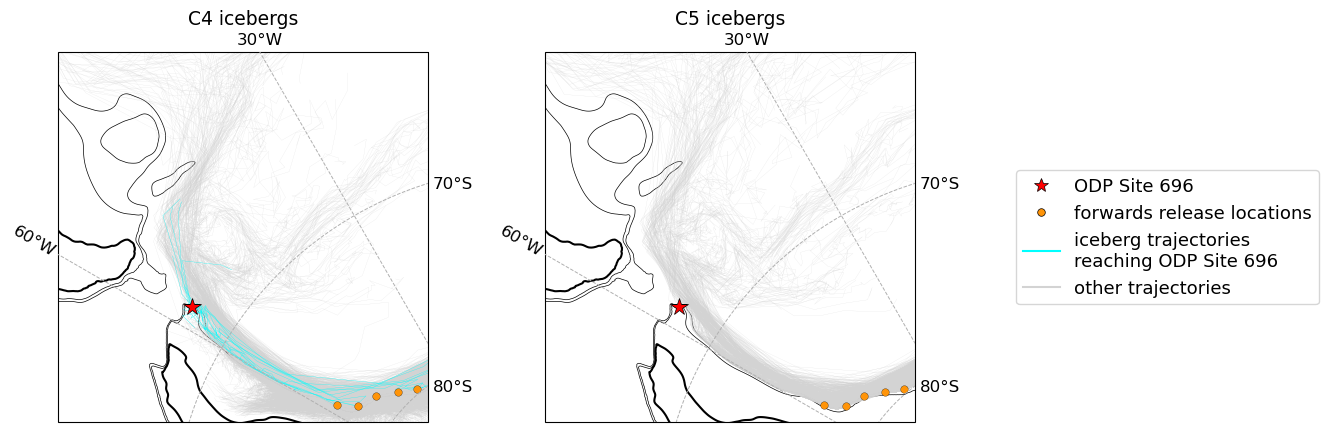

In [19]:
### Prepare figure
fig = plt.figure(figsize=(12,4.8))

gs = GridSpec(1, 1)                                                                        # figure: 1 row, 1 column
gs0 = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0], wspace=0.1, width_ratios=(1, 1))   # split top row: 1 row, 2 columns

axs = [fig.add_subplot(g, projection=ccrs.SouthPolarStereo()) for g in (gs0[0,0], gs0[0,1])]

for dat, name, label, ax in zip(data_z, names_z, labels_z, axs):
    print(f'Start plotting {name}...')

    ax = prepare_outline_ODP_plot(ax)
    ax.set_title(f'{str(label)}', fontsize=13.5)

    # Bathymetry
    jm = ax.contour(lons[50:700,1000:1700], lats[50:700,1000:1700], bath[50:700,1000:1700], levels=[-500,-250], linewidths=.5, colors='k',
                    linestyles='-', transform=ccrs.PlateCarree(), zorder=0)
    for d in jm.collections:
        d.set_rasterized(True)
    
    # ODP Site 696
    ax.plot(x696_le, y696_le, color='r', marker='*', markersize=13, markeredgecolor='k', markeredgewidth=.5, transform=ccrs.PlateCarree(), zorder=3)
    
    # Trajectories
    ax.plot(tcoord_dict[name]['tlon'].T, tcoord_dict[name]['tlat'].T, transform=ccrs.Geodetic(), linewidth=.2, zorder=2, color='cyan', rasterized=True)
    print(f'   trajectories reaching ODP plotted...')
    ax.plot(dat['lon'].T, dat['lat'].T, transform=ccrs.Geodetic(), linewidth=.1, zorder=1, color='lightgrey', rasterized=True)
    print(f'   other trajectories plotted...')
    
    # Release locations
    ax.scatter(lons_fw, lats_fw, transform=ccrs.PlateCarree(), color='xkcd:tangerine', zorder=3, s=30, edgecolor='k', linewidths=0.2)
    
    # Legend
    if name == 'C5g':
        handles, labels = ax.get_legend_handles_labels()
        ODP = Line2D([0], [0], label='ODP Site 696', marker='*', markersize=np.sqrt(100),
                     markeredgecolor='k', markerfacecolor='r', markeredgewidth=.5, linestyle='')
        handles.append(ODP)
        rel = Line2D([0], [0], label='forwards release locations', marker='o', markersize=np.sqrt(30),
                     markeredgecolor='k', markerfacecolor='xkcd:tangerine', markeredgewidth=.5, linestyle='')
        handles.append(rel)
        suc = Line2D([0], [0], label='iceberg trajectories \nreaching ODP Site 696', color='cyan')
        handles.append(suc)
        oth = Line2D([0], [0], label='other trajectories', color='lightgrey')
        handles.append(oth)
        ax.legend(handles=handles, loc='center left', bbox_to_anchor=(1.25, .5), fontsize='13')
        
print('Saving figure...')
plt.savefig(f'figures/Paper/FDFWTrajectoriesZoom.pdf', bbox_inches='tight', dpi=300)
print(f'Figure saved.')
plt.show()

## Percentages

Analyse what percentage of the icebergs released at a specific forward release location reaches ODP Site 696 at some point along its trajectory.

Main simulations: Figure 4

In [20]:
### Load data
data = [C1g_filtered, C2g_filtered, C3g_filtered, C4g_filtered, C5g_filtered, C4g_filtered, SF_filtered]
names = ['C1g', 'C2g', 'C3g', 'C4g', 'C5g', 'C4gd', 'SF']
labels = ['C1', 'C2', 'C3', 'C4', 'C5', 'C4 - doubled target radius', 'C4 - surface only']

In [21]:
### Set colours
cols = ['#332288', '#117733', '#44AA99', '#88CCEE', '#DDCC77', '#CC6677', '#AA4499']   # lines
cols_carter = ['#d2d3d4','#ada4ce','#e5a787','#cc393c','#d578aa','#d6c7d0']            # colourscheme from regions used in Carter et al. (2014)

In [22]:
### Prepare data
print('Appendix A')
df2_data_list = []

for idx, dat in enumerate(data):
    
    # Create arrays with release locations of all trajectories individually
    lonsar = np.tile(lons_fw, int(len(dat['trajectory'])/len(lons_fw)))
    latsar = np.tile(lats_fw, int(len(dat['trajectory'])/len(lats_fw)))
  
    minvals = np.nanmin(dat['distance'], axis=1)               # find minimum distance to ODP Site 696 for each iceberg
    gcd_threshold = gcd if names[idx] != 'C4gd' else 2 * gcd   # set the threshold distance to one or two times the gridcell distance
    mask = minvals <= gcd_threshold                            # select trajectories that reach ODP Site 696 within the gridcell distance
    
    # Set coordinates to nan when not reaching ODP Site 696
    lonsar[~mask] = np.nan
    latsar[~mask] = np.nan
    
    # Create dataframe to group release location coordinates and drop those that do not reach ODP Site 696
    df = pd.DataFrame(data={'lat': latsar, 'lon': lonsar})
    df.dropna(inplace=True)
    
    # Calculate fraction of releases reaching ODP ...
    tot    = len(dat['trajectory'])
    cnt    = np.bincount(np.searchsorted(np.sort(lons_fw), df['lon']), minlength=len(lons_fw))
    sm     = sum(cnt)
    cnt_t  = len(df)
    frac_t = cnt_t / tot                 # ... in total
    frac   = cnt / (tot / len(lons_fw))  # ... per site

    # Create dataframe ...
    df2 = pd.DataFrame(data={'lon': np.sort(lons_fw),
                             'lat': np.array([x for _, x in sorted(zip(lons_fw, lats_fw))]),
                             'cnt': cnt,
                             'frac': frac})
    df2.reset_index(drop=True, inplace=True)   # change order release locations: 0=closest, 28=furthest
    df2_data_list.append(df2)
    
    # Print number/fraction of releases per simulation that reach ODP Site 696 (Appendix A)
    print(f'   Of the in total {tot} trajectories of {names[idx]}, {sm} = {cnt_t} or {frac_t*100:1.3f}% reach ODP Site 696.')

Appendix A
   Of the in total 45575 trajectories of C1g, 0 = 0 or 0.000% reach ODP Site 696.
   Of the in total 45575 trajectories of C2g, 0 = 0 or 0.000% reach ODP Site 696.
   Of the in total 45575 trajectories of C3g, 0 = 0 or 0.000% reach ODP Site 696.
   Of the in total 45575 trajectories of C4g, 13 = 13 or 0.029% reach ODP Site 696.
   Of the in total 45575 trajectories of C5g, 0 = 0 or 0.000% reach ODP Site 696.
   Of the in total 45575 trajectories of C4gd, 30 = 30 or 0.066% reach ODP Site 696.
   Of the in total 45575 trajectories of SF, 483 = 483 or 1.060% reach ODP Site 696.


Start plotting...
Figure saved.


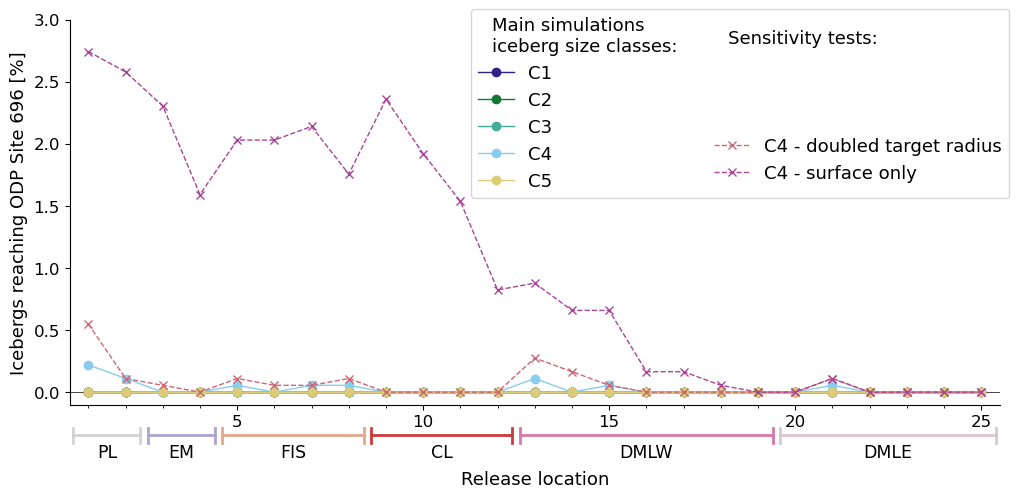

In [23]:
### Plot
print('Start plotting...')

fig, ax = plt.subplots(1, 1, figsize=(12,5))

# Plot data
for df2, name, label, col in zip(df2_data_list, names, labels, cols):
    if name == 'C4gd' or name == 'C4gs' or name == 'SF':
        ax.plot(df2.index, df2['frac']*100., linestyle='--', marker='x', linewidth=1, markersize=6, label=f'{label}', zorder=5, color=col)
    else:
        ax.plot(df2.index, df2['frac']*100., linestyle='-',  marker='o', linewidth=1, markersize=6, label=f'{label}', zorder=5, color=col)

# Plot horizontal line through y=0
ax.axhline(0, linewidth=.5, color='k', zorder=0)

# Fix labels (index 0 = release location 1)
ax.set_xticks([4, 9, 14, 19, 24])
ax.set_xticklabels(['5', '10', '15', '20', '25'], fontsize=12)
ax.set_xticks([0, 1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21, 22, 23], minor=True)
ax.tick_params(axis='y', labelsize=12)

# Set axis limits
ax.set_xlim(-0.5, 24.5)
ax.set_ylim(-0.1,  3.)

# End figure
ax.set_xlabel('Release location', fontsize=13)
ax.xaxis.set_label_coords(.5, -.17)
ax.set_ylabel('Icebergs reaching ODP Site 696 [%]', fontsize=13)

# Plot and adjust legend
h, l = ax.get_legend_handles_labels()               # get handles/labels from plot
ph = [ax.plot([], marker="", ls="")[0]]*2           # create empty labels 
handles = ph[:1] + h[:5] + ph[:] + ph[:] + h[5:]    # set new handles
labs = ['Main simulations \niceberg size classes:'] + l[:5] + ['Sensitivity tests:'] + [''] + [''] + [''] + l[5:]
leg = ax.legend(handles, labs, ncol=2, fontsize=13, loc='upper right', bbox_to_anchor=(1.02, 1.05))

for vpack in leg._legend_handle_box.get_children():
    for hpack in vpack.get_children()[:1]:
        hpack.get_children()[0].set_width(0)

# Hide the right and top spines
ax.spines[['right', 'top']].set_visible(False)

# Add regions below x-axis
trans = ax.get_xaxis_transform()
annotations = [('PL',    0.5, 1.),
               ('EM',    2.5, 1.),
               ('FIS',   5.5, 2.),
               ('CL',    9.5, 2.),
               ('DMLW', 15.,  3.5),
               ('DMLE', 21.5, 3.)]

for idx, (label, x, d) in enumerate(annotations):
    ax.annotate(label, xy=(x, -.1), xycoords=trans, ha='center', va='top', fontsize=12.5)
    ax.plot([x-d+.1, x+d-.1], [-.08, -.08], color=cols_carter[idx], lw=2, transform=trans, clip_on=False)
    ax.plot([x-d+.1, x-d+.1], [-.1, -.06],  color=cols_carter[idx], lw=2, transform=trans, clip_on=False)
    ax.plot([x+d-.1, x+d-.1], [-.1, -.06],  color=cols_carter[idx], lw=2, transform=trans, clip_on=False)

plt.savefig(f'figures/Paper/F04FWPercentages.pdf', bbox_inches='tight', dpi=300)
print(f'Figure saved.')
plt.show()

Supplement: Figure S3.2

In [24]:
### Load data
data_sup = [PF_filtered, C4gs_filtered, C5a_filtered]
names_sup = ['PF', 'C4gs', 'C5a']
labels_sup = ['Passive particles', 'C4 icebergs - shifted position', 'C5 icebergs - adapted basal melt']

In [25]:
### Set colours
cols_sup = ['#332288', '#117733', '#44AA99', '#88CCEE']   # lines

In [26]:
### Prepare data
print('Table S3.1')
df2_data_list = []

for idx, dat in enumerate(data_sup):
    
    # Create arrays with release locations of all trajectories individually
    lonsar = np.tile(lons_fw, int(len(dat['trajectory'])/len(lons_fw)))
    latsar = np.tile(lats_fw, int(len(dat['trajectory'])/len(lats_fw)))
  
    minvals = np.nanmin(dat['distance'], axis=1)   # find minimum distance to ODP Site 696 for each iceberg
    gcd_threshold = gcd                            # set the threshold distance to the gridcell distance
    mask = minvals <= gcd_threshold                # select trajectories that reach ODP Site 696 within the gridcell distance
    
    # Set coordinates to nan when not reaching ODP Site 696
    lonsar[~mask] = np.nan
    latsar[~mask] = np.nan
    
    # Create dataframe to group release location coordinates and drop those that do not reach ODP Site 696
    df = pd.DataFrame(data={'lat': latsar, 'lon': lonsar})
    df.dropna(inplace=True)
    
    # Calculate fraction of releases reaching ODP ...
    tot    = len(dat['trajectory'])
    cnt    = np.bincount(np.searchsorted(np.sort(lons_fw), df['lon']), minlength=len(lons_fw))
    sm     = sum(cnt)
    cnt_t  = len(df)
    frac_t = cnt_t / tot                 # ... in total
    frac   = cnt / (tot / len(lons_fw))  # ... per site

    # Create dataframe ...
    df2 = pd.DataFrame(data={'lon': np.sort(lons_fw),
                             'lat': np.array([x for _, x in sorted(zip(lons_fw, lats_fw))]),
                             'cnt': cnt,
                             'frac': frac})
    df2.reset_index(drop=True, inplace=True)   # change order release locations: 0=closest, 28=furthest
    df2_data_list.append(df2)
    
    # Print number/fraction of releases per simulation that reach ODP Site 696 (Appendix A)
    print(f'   Of the in total {tot} trajectories of {names_sup[idx]}, {sm} = {cnt_t} or {frac_t*100:1.3f}% reach ODP Site 696.')

Table S3.1
   Of the in total 45575 trajectories of PF, 557 = 557 or 1.222% reach ODP Site 696.
   Of the in total 45575 trajectories of C4gs, 1 = 1 or 0.002% reach ODP Site 696.
   Of the in total 45575 trajectories of C5a, 1930 = 1930 or 4.235% reach ODP Site 696.


Start plotting...
Figure saved.


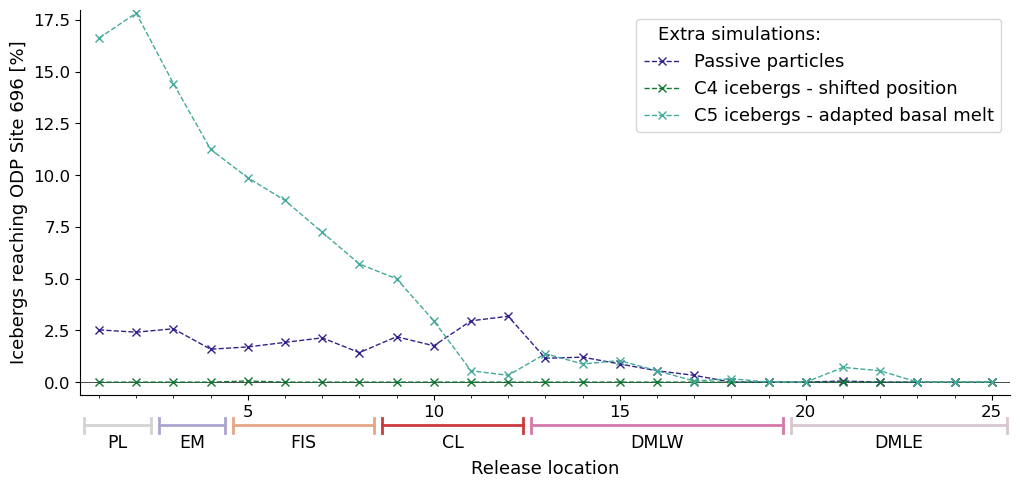

In [27]:
### Plot
print('Start plotting...')

fig, ax = plt.subplots(1, 1, figsize=(12,5))

# Plot data
for df2, name, label, col in zip(df2_data_list, names_sup, labels_sup, cols_sup):
    ax.plot(df2.index, df2['frac']*100., linestyle='--', marker='x', linewidth=1, markersize=6, label=f'{label}', zorder=5, color=col)

# Plot horizontal line through y=0
ax.axhline(0, linewidth=.5, color='k', zorder=0)

# Fix labels (index 0 = release location 1)
ax.set_xticks([4, 9, 14, 19, 24])
ax.set_xticklabels(['5', '10', '15', '20', '25'], fontsize=12)
ax.set_xticks([0, 1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21, 22, 23], minor=True)
ax.tick_params(axis='y', labelsize=12)

# Set axis limits
ax.set_xlim(-0.5, 24.5)
ax.set_ylim(-18./30.,18.)

# End figure
ax.set_xlabel('Release location', fontsize=13)
ax.xaxis.set_label_coords(.5, -.17)
ax.set_ylabel('Icebergs reaching ODP Site 696 [%]', fontsize=13)

for vpack in leg._legend_handle_box.get_children():
    for hpack in vpack.get_children()[:1]:
        hpack.get_children()[0].set_width(0)

# Plot and adjust legend
h, l = ax.get_legend_handles_labels()       # get handles/labels from plot
ph = [ax.plot([], marker="", ls="")[0]]*4   # create empty labels 
handles = ph[:1] + h[:5] + ph[:]            # set new handles
labs = ['Extra simulations:'] + l[:]
leg = ax.legend(handles, labs, ncol=1, fontsize=13)

for vpack in leg._legend_handle_box.get_children():
    for hpack in vpack.get_children()[:1]:
        hpack.get_children()[0].set_width(0)

# Hide the right and top spines
ax.spines[['right', 'top']].set_visible(False)

# Add regions below x-axis
trans = ax.get_xaxis_transform()
annotations = [('PL',    0.5, 1.),
               ('EM',    2.5, 1.),
               ('FIS',   5.5, 2.),
               ('CL',    9.5, 2.),
               ('DMLW', 15.,  3.5),
               ('DMLE', 21.5, 3.)]

for idx, (label, x, d) in enumerate(annotations):
    ax.annotate(label, xy=(x, -.1), xycoords=trans, ha='center', va='top', fontsize=12.5)
    ax.plot([x-d+.1, x+d-.1], [-.08, -.08], color=cols_carter[idx], lw=2, transform=trans, clip_on=False)
    ax.plot([x-d+.1, x-d+.1], [-.1, -.06],  color=cols_carter[idx], lw=2, transform=trans, clip_on=False)
    ax.plot([x+d-.1, x+d-.1], [-.1, -.06],  color=cols_carter[idx], lw=2, transform=trans, clip_on=False)

plt.savefig(f'figures/Paper/FS03FWPercentages.pdf', bbox_inches='tight', dpi=300)
print(f'Figure saved.')
plt.show()

## Iceberg lifetime

Study the lifetimes of the released icebergs.

Main simulations: Appendix E

In [28]:
### Date of release
dr = pd.date_range(start='01/01/2038', end='12/31/2042', freq='d')                # set range of dates
dates1 = dr[(dr.day != 29) | (dr.month != 2)]                                     # remove February 29th
dates = dates1[(dates1.day != 1) | (dates1.month != 3) | (dates1.year != 2040)]   # remove date empty datafile
timestamps = np.expand_dims(np.array(dates), axis=1)                              # change shape
timear = np.repeat(timestamps[:-1], len(lons_fw))                                 # array of iceberg release times (repeat dates for each release location)

In [29]:
### Load and prepare data
dat = C4g_filtered.copy()
dat = dat.drop(['Mvr', 'Mbr', 'Mer'])   # drop meltterms from dataset

dat['lt'] = (('trajectory', 'obs'), np.zeros_like(dat['time'].astype('timedelta64[D]')))                     # add variable to store the iceberg lifetime
dat['lt'] = (('trajectory', 'obs'), (dat['time'].values - timear[:, np.newaxis]).astype('timedelta64[D]'))   # calculate days between data point and release time

name = 'C4'
label = 'C4 icebergs'

First, determine the time passed since release of icebergs of size class C4 along their trajectory.

Trajectories plotted...
Saving figure...


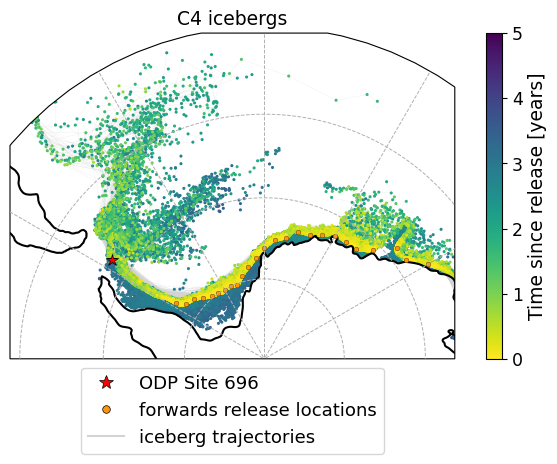

In [30]:
### Plot
fig, ax = plt.subplots(nrows=1,ncols=1,
                        subplot_kw={'projection': ccrs.SouthPolarStereo()},
                        figsize=(8,4.7))

ax = prepare_outline_trajectory_plot(ax)
ax.set_title(f'{str(label)}', fontsize=13.5)

# ODP Site 696
ax.plot(x696_le, y696_le, color='r', marker='*', markersize=9, markeredgecolor='black', markeredgewidth=.5, transform=ccrs.PlateCarree(), zorder=3)

# Release locations
ax.scatter(lons_fw, lats_fw, transform=ccrs.PlateCarree(), color='xkcd:tangerine', zorder=3,
           s=12, edgecolor='k', linewidths=0.2)

# Trajectories
ax.plot(dat['lon'].T, dat['lat'].T, transform=ccrs.PlateCarree(), linewidth=.1, zorder=0, color='lightgrey', rasterized=True)
print(f'Trajectories plotted...')

cm = ax.scatter(dat['lon'], dat['lat'], transform=ccrs.PlateCarree(), s=1.5, zorder=1, c=dat['lt']/86400e9,
                cmap='viridis_r', vmin=0, vmax=365*5, rasterized=True)
cb = fig.colorbar(cm, ax=ax, ticks=[0, 365, 2*365, 3*365, 4*365, 5*365], anchor=(0.0,0.0), shrink=.9)
cb.set_label(label='Time since release [years]', size=13.5)
cb.ax.set_yticklabels(['0', '1', '2', '3', '4', '5'], fontsize=12.5)

# Legend
handles, labels = ax.get_legend_handles_labels()
ODP = Line2D([0], [0], label='ODP Site 696', marker='*', markersize=np.sqrt(100),
             markeredgecolor='k', markerfacecolor='r', markeredgewidth=.5, linestyle='')
handles.append(ODP)
rel = Line2D([0], [0], label='forwards release locations', marker='o', markersize=np.sqrt(30),
             markeredgecolor='k', markerfacecolor='xkcd:tangerine', markeredgewidth=.5, linestyle='')
handles.append(rel)
oth = Line2D([0], [0], label='iceberg trajectories', color='lightgrey')
handles.append(oth)

pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.width, pos.height * 0.9])
ax.legend(handles=handles, loc='lower center', bbox_to_anchor=(0.5, -0.32), fontsize='13')

print('Saving figure...')
plt.savefig(f'figures/Paper/FEcLifetimeSpatial.pdf', dpi=300)
plt.show()

Second, calculate the iceberg lifetimes.

In [31]:
### Half-life calculation function

def half_life(dat, mass):
    drp = dat.drop_vars(['Mbr', 'Mer', 'Mvr', 'distance', 'lat', 'lon', 'z'])
    sel = drp.copy()
    half_1 = sel.isel(obs=0)
    
    # Add initial values to dataset: times of release and initial mass
    half_1['time'].values = timear
    half_1['M'].values = np.ones(len(timear)) * mass
    half_f = xr.concat([half_1, sel], dim='obs')
    
    # Obtain indices where last value of true (point where iceberg becomes smaller than half its initial size)
    M_sel = half_f.where(half_f['M'] > (mass / 2.))
    not_null = M_sel['M'].notnull()                                          # True values
    tst = not_null.to_numpy()
    indices = tst.shape[1] - np.argmax(tst[:, ::-1], axis=1)                 # index of last True value (first value smaller than half)
    all_false = np.logical_not(tst).all(axis=1)
    indices[all_false] = 0                                                   # set to 0 if all False
    
    # Number of days since release to half mass = half-life time
    days = np.ones(len(timear))
    for i, ind in enumerate(indices):
        if ind == 63:
            days[i] = np.nan
        else:
            days[i] = (half_f['time'][i, ind].values - half_f['time'][i, 0].values).astype('timedelta64[D]')
    
    return days

Maximum lifetime for icebergs C4

In [32]:
### Prepare data
# Iceberg lifetime
C4maxs = dat['lt'].max(skipna=True, dim='obs')

# Iceberg half-life time
days4 = half_life(C4g_filtered, 10000*10000/1.5*500*850.0)
days4 = np.where(np.isnat(days4.astype('timedelta64[D]')), np.nan, days4)
print(f'Mean iceberg half-life time for C4: {np.nanmean(days4)}')

Mean iceberg half-life time for C4: 329.5060638888155


Saving figure...


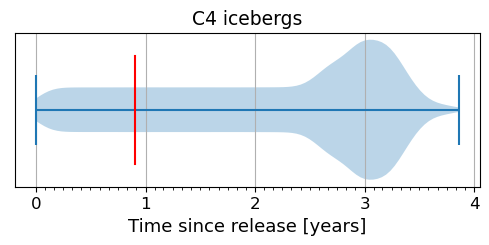

In [33]:
### Plot

fig = plt.figure(figsize=(6,2))
ax = plt.axes()

# Violin plot iceberg lifetime with marker mean half-life
ax.violinplot(C4maxs.values/np.timedelta64(1,'D'), vert=False)
ax.axvline(np.nanmean(days4), ymin=.15, ymax=.85, c='r')

# Set grid
ax.xaxis.grid(True)
ax.set_xticks([0, 365, 2*365, 3*365, 4*365], labels=['0', '1', '2', '3', '4'], fontsize=12)
ax.set_xticks([0,31,59,90,120,151,181,212, 243, 273, 304, 334,
               396, 424, 455, 485, 516, 546, 577, 608, 638, 669, 699, 
               761, 789, 820, 850, 881, 911, 942, 973, 1003, 1034, 1064,
               1126, 1154, 1185, 1215, 1246, 1276, 1307, 1338, 1368, 1399, 1429], minor=True)

ax.set_yticks([])
ax.set_xlabel('Time since release [years]', fontsize=13)

ax.set_title('C4 icebergs', fontsize=13.5)

print('Saving figure...')
plt.savefig(f'figures/Paper/FEbLifetimeC4.pdf', bbox_inches='tight', dpi=300)
plt.show()

Maximum lifetime for icebergs C3

In [34]:
### Load and prepare data
C3g_cp = C3g_filtered.copy()
C3g_cp = C3g_cp.drop(['Mvr', 'Mbr', 'Mer', 'lat', 'lon', 'M'])

C3g_cp['lt'] = (('trajectory', 'obs'), np.zeros_like(C3g_cp['time'].astype('timedelta64[D]')))                     # add variable to store the iceberg lifetime
C3g_cp['lt'] = (('trajectory', 'obs'), (C3g_cp['time'].values - timear[:, np.newaxis]).astype('timedelta64[D]'))   # calculate days between data point and release time

In [35]:
### Prepare data
# Iceberg lifetime
C3maxs = C3g_cp['lt'].max(skipna=True, dim='obs')

# Iceberg half-life time
days3 = half_life(C3g_filtered, 1000*1000/1.5*200*850.0)
days3 = np.where(np.isnat(days3.astype('timedelta64[D]')), np.nan, days3)
print(f'Mean maximum lifetime C3: {np.nanmean(days3)}')

Mean maximum lifetime C3: 46.214818799166274


Saving figure...


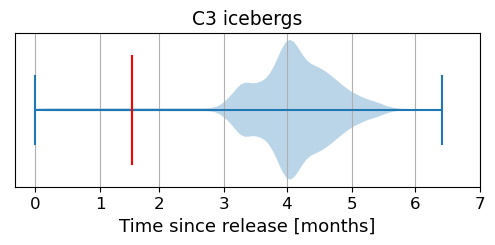

In [36]:
fig = plt.figure(figsize=(6,2))
ax = plt.axes()

# plot violin plot
ax.violinplot(C3maxs.values/np.timedelta64(1,'D'), vert=False)
ax.axvline(np.nanmean(days3), ymin=.15, ymax=.85, c='r')

ax.xaxis.grid(True)
ax.set_xticks([0,31,59,90,120,151,181,212], labels=['0', '1', '2', '3', '4', '5', '6', '7'], fontsize=12)

ax.set_yticks([])
ax.set_xlabel('Time since release [months]', fontsize=13)

ax.set_title('C3 icebergs', fontsize=13.5)

print('Saving figure...')
plt.savefig(f'figures/Paper/FEaLifetimeC3.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Melt

We are interested in the magnitudes and spatial variability of the iceberg melt (terms).

First, study the patterns for icebergs of size class C4 (main simulations).

In [37]:
### Load and prepare data
dat = C4g_filtered
name = 'C4g'

Mv = C4g_filtered['Mvr'].values
Mb = C4g_filtered['Mbr'].values
Me = C4g_filtered['Mer'].values
plon = C4g_filtered['lon'].values
plat = C4g_filtered['lat'].values

melts = [Mv, Mb, Me, Mv+Mb+Me]
terms = ['Buoyant convection', 'Basal melt', 'Wave erosion', 'Total melt']

Main simulations: Figure 4.1

Start preparation C4g...
   trajectories...
   scatter...
   colorbars...
   and finalise.


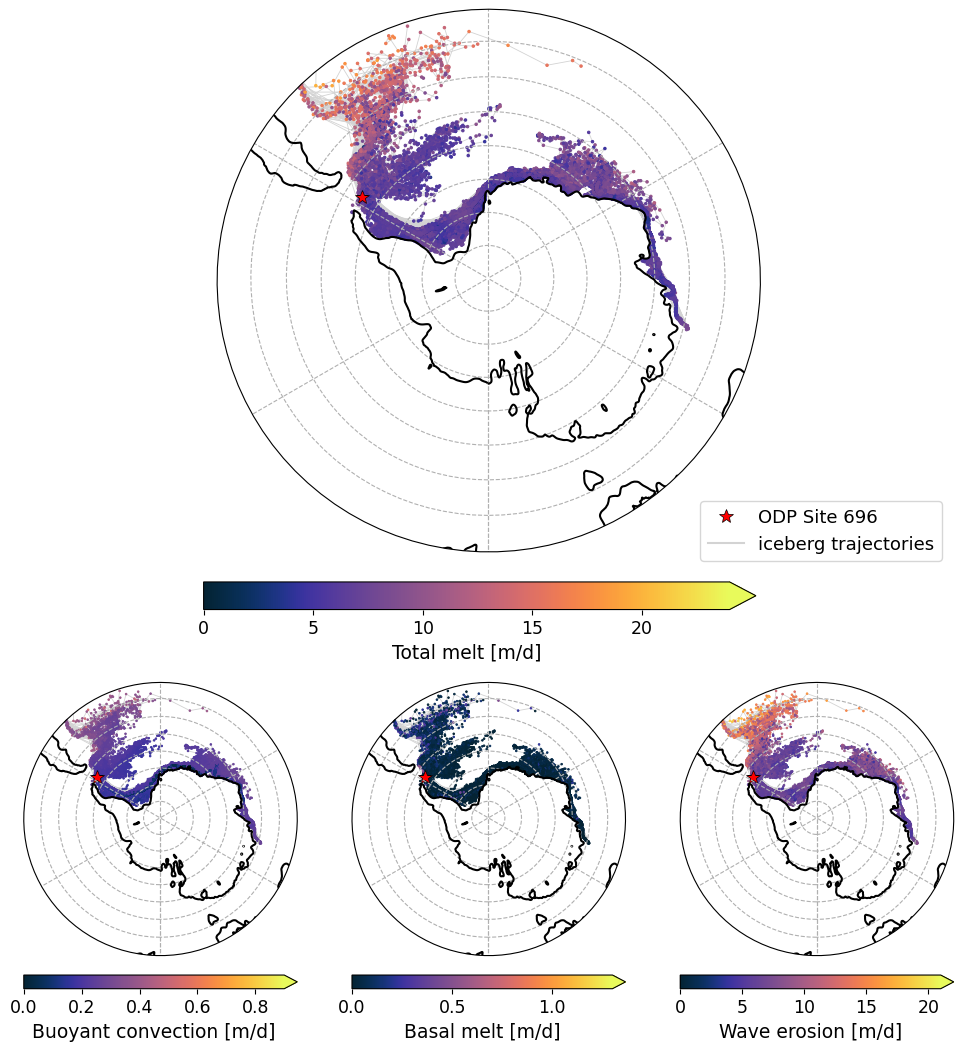

In [38]:
### Plot fields and icebergs
fig = plt.figure(figsize=(12,13.3))

# Setup axes
gs = GridSpec(5,3)
ax = {}
ax0 = fig.add_subplot(gs[0:3,0:3], projection=ccrs.SouthPolarStereo())
ax1 = fig.add_subplot(gs[3:,0], projection=ccrs.SouthPolarStereo())
ax2 = fig.add_subplot(gs[3:,1], projection=ccrs.SouthPolarStereo())
ax3 = fig.add_subplot(gs[3:,2], projection=ccrs.SouthPolarStereo())

# Prepare
print(f'Start preparation {name}...')
ax0 = prepare_outline_SPS_plot(ax0)
normalize0 = colors.Normalize(vmin=0., vmax=24.) # total
ax1 = prepare_outline_SPS_plot(ax1)
normalize1 = colors.Normalize(vmin=0., vmax=.9)  # buoyant
ax2 = prepare_outline_SPS_plot(ax2)
normalize2 = colors.Normalize(vmin=0., vmax=1.3) # basal
ax3 = prepare_outline_SPS_plot(ax3)
normalize3 = colors.Normalize(vmin=0., vmax=21.) # wave

# Trajectories
print(f'   trajectories...')
ax0.plot(plon.T, plat.T, transform=ccrs.Geodetic(), linewidth=.6, color='lightgrey', zorder=0, rasterized=True)
ax1.plot(plon.T, plat.T, transform=ccrs.Geodetic(), linewidth=.6, color='lightgrey', zorder=0, rasterized=True)
ax2.plot(plon.T, plat.T, transform=ccrs.Geodetic(), linewidth=.6, color='lightgrey', zorder=0, rasterized=True)
ax3.plot(plon.T, plat.T, transform=ccrs.Geodetic(), linewidth=.6, color='lightgrey', zorder=0, rasterized=True)

# Points
print(f'   scatter...')
for i in range(len(dat['trajectory'])):
    cf0 = ax0.scatter(plon[i,1:], plat[i,1:], transform=ccrs.PlateCarree(), c=(Mv+Mb+Me)[i,1:]*86400.,
                      cmap=cmo.cm.thermal, linewidth=.8, s=3, norm=normalize0, zorder=1, rasterized=True)
    cf1 = ax1.scatter(plon[i,1:], plat[i,1:], transform=ccrs.PlateCarree(), c=(Mv[i,1:])*86400.,
                      cmap=cmo.cm.thermal, linewidth=.6, s=1.5, norm=normalize1, zorder=1, rasterized=True)
    cf2 = ax2.scatter(plon[i,1:], plat[i,1:], transform=ccrs.PlateCarree(), c=(Mb[i,1:])*86400.,
                      cmap=cmo.cm.thermal, linewidth=.6, s=1.5, norm=normalize2, zorder=1, rasterized=True)
    cf3 = ax3.scatter(plon[i,1:], plat[i,1:], transform=ccrs.PlateCarree(), c=(Me[i,1:])*86400.,
                      cmap=cmo.cm.thermal, linewidth=.6, s=1.5, norm=normalize3, zorder=1, rasterized=True)

# Colorbars
print(f'   colorbars...')
cb = plt.colorbar(cf0, ax=ax0, orientation='horizontal', fraction=0.046, pad=0.05, extend='max')
cb.set_label('Total melt [m/d]', size=13.5)
cb.ax.tick_params(labelsize=12.5)
cb = plt.colorbar(cf1, ax=ax1, orientation='horizontal', pad=0.05, extend='max')
cb.set_label('Buoyant convection [m/d]', size=13.5)
cb.ax.tick_params(labelsize=12.5)
cb = plt.colorbar(cf2, ax=ax2, orientation='horizontal', pad=0.05, extend='max')
cb.set_label('Basal melt [m/d]', size=13.5)
cb.ax.tick_params(labelsize=12.5)
cb = plt.colorbar(cf3, ax=ax3, orientation='horizontal', pad=0.05, extend='max')
cb.set_label('Wave erosion [m/d]', size=13.5)
cb.ax.tick_params(labelsize=12.5)

# Legend
handles, labels = ax0.get_legend_handles_labels()
ODP = Line2D([0], [0], label='ODP Site 696', marker='*', markersize=np.sqrt(100),
             markeredgecolor='k', markerfacecolor='r', markeredgewidth=.5, linestyle='')
handles.append(ODP)
tra = Line2D([0], [0], label='iceberg trajectories', color='lightgrey')
handles.append(tra)
ax0.legend(handles=handles, bbox_to_anchor=(1.35, .11), fontsize='13')

print(f'   and finalise.')
plt.savefig(f'figures/Paper/F07MeltC4.pdf', bbox_inches='tight', dpi=300)
plt.show()

Similarly, study the difference in melt when only using surface fields for iceberg size class C4 (SF).

Supplements: Figure S3.6

In [39]:
### Load and prepare data
dat = SF_filtered
name = 'SF'

Mvs = SF_filtered['Mvr'].values
Mbs = SF_filtered['Mbr'].values
Mes = SF_filtered['Mer'].values
plons = SF_filtered['lon'].values
plats = SF_filtered['lat'].values

meltss = [Mvs, Mbs, Mes, Mvs+Mbs+Mes]
terms = ['Buoyant convection', 'Basal melt', 'Wave erosion', 'Total melt']

Start preparation SF...
   trajectories...
   scatter...
   colorbars...
   and finalise.


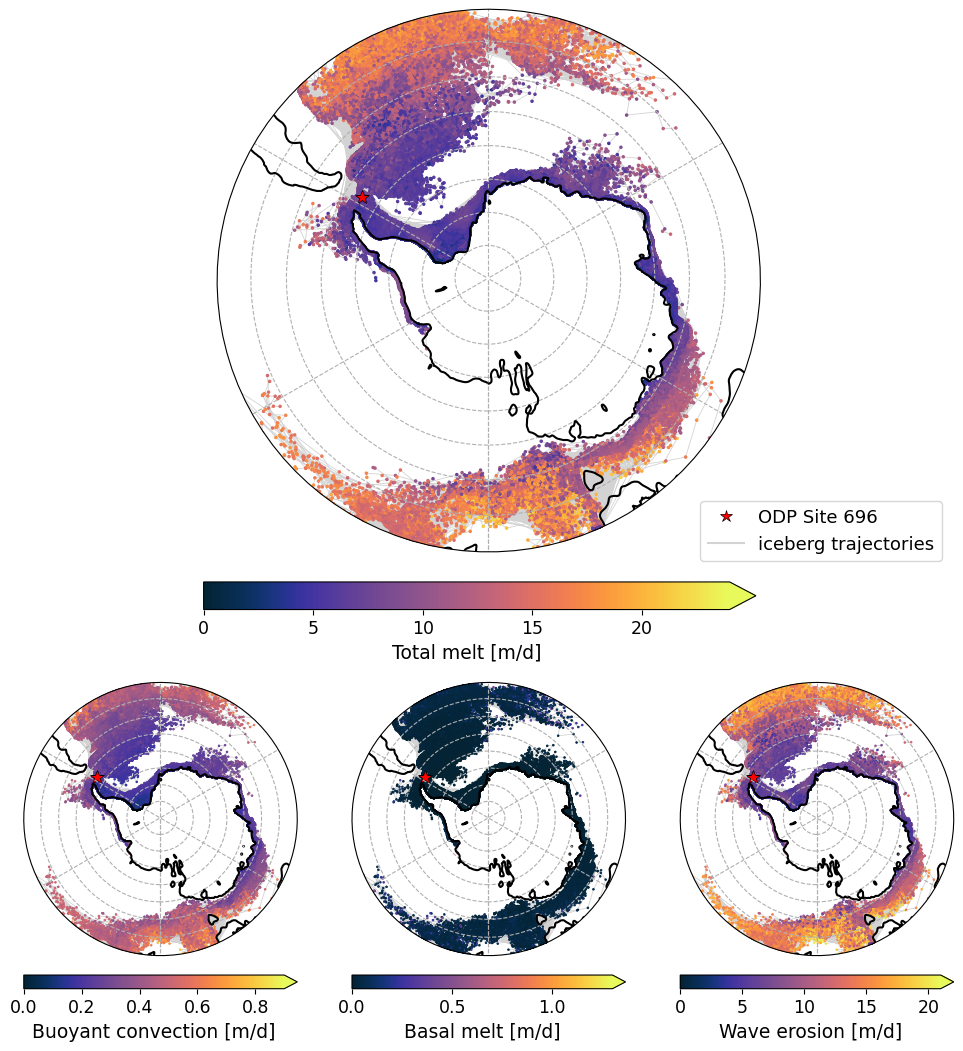

In [40]:
### Plot fields and icebergs
fig = plt.figure(figsize=(12,13.3))

# Setup axes
gs = GridSpec(5,3)
ax = {}
ax0 = fig.add_subplot(gs[0:3,0:3], projection=ccrs.SouthPolarStereo())
ax1 = fig.add_subplot(gs[3:,0], projection=ccrs.SouthPolarStereo())
ax2 = fig.add_subplot(gs[3:,1], projection=ccrs.SouthPolarStereo())
ax3 = fig.add_subplot(gs[3:,2], projection=ccrs.SouthPolarStereo())

# Prepare
print(f'Start preparation {name}...')
ax0 = prepare_outline_SPS_plot(ax0)
normalize0 = colors.Normalize(vmin=0., vmax=24.) # total
ax1 = prepare_outline_SPS_plot(ax1)
normalize1 = colors.Normalize(vmin=0., vmax=.9)  # buoyant
ax2 = prepare_outline_SPS_plot(ax2)
normalize2 = colors.Normalize(vmin=0., vmax=1.3) # basal
ax3 = prepare_outline_SPS_plot(ax3)
normalize3 = colors.Normalize(vmin=0., vmax=21.) # wave

# Trajectories
print(f'   trajectories...')
ax0.plot(plons.T, plats.T, transform=ccrs.Geodetic(), linewidth=.6, color='lightgrey', zorder=0, rasterized=True)
ax1.plot(plons.T, plats.T, transform=ccrs.Geodetic(), linewidth=.6, color='lightgrey', zorder=0, rasterized=True)
ax2.plot(plons.T, plats.T, transform=ccrs.Geodetic(), linewidth=.6, color='lightgrey', zorder=0, rasterized=True)
ax3.plot(plons.T, plats.T, transform=ccrs.Geodetic(), linewidth=.6, color='lightgrey', zorder=0, rasterized=True)

# Points
print(f'   scatter...')
for i in range(len(dat['trajectory'])):
    cf0 = ax0.scatter(plons[i,1:], plats[i,1:], transform=ccrs.PlateCarree(), c=(Mvs+Mbs+Mes)[i,1:]*86400.,
                      cmap=cmo.cm.thermal, linewidth=.8, s=3, norm=normalize0, zorder=1, rasterized=True)
    cf1 = ax1.scatter(plons[i,1:], plats[i,1:], transform=ccrs.PlateCarree(), c=(Mvs[i,1:])*86400.,
                      cmap=cmo.cm.thermal, linewidth=.6, s=1.5, norm=normalize1, zorder=1, rasterized=True)
    cf2 = ax2.scatter(plons[i,1:], plats[i,1:], transform=ccrs.PlateCarree(), c=(Mbs[i,1:])*86400.,
                      cmap=cmo.cm.thermal, linewidth=.6, s=1.5, norm=normalize2, zorder=1, rasterized=True)
    cf3 = ax3.scatter(plons[i,1:], plats[i,1:], transform=ccrs.PlateCarree(), c=(Mes[i,1:])*86400.,
                      cmap=cmo.cm.thermal, linewidth=.6, s=1.5, norm=normalize3, zorder=1, rasterized=True)

# Colorbars
print(f'   colorbars...')
cb = plt.colorbar(cf0, ax=ax0, orientation='horizontal', fraction=0.046, pad=0.05, extend='max')
cb.set_label('Total melt [m/d]', size=13.5)
cb.ax.tick_params(labelsize=12.5)
cb = plt.colorbar(cf1, ax=ax1, orientation='horizontal', pad=0.05, extend='max')
cb.set_label('Buoyant convection [m/d]', size=13.5)
cb.ax.tick_params(labelsize=12.5)
cb = plt.colorbar(cf2, ax=ax2, orientation='horizontal', pad=0.05, extend='max')
cb.set_label('Basal melt [m/d]', size=13.5)
cb.ax.tick_params(labelsize=12.5)
cb = plt.colorbar(cf3, ax=ax3, orientation='horizontal', pad=0.05, extend='max')
cb.set_label('Wave erosion [m/d]', size=13.5)
cb.ax.tick_params(labelsize=12.5)

# Legend
handles, labels = ax0.get_legend_handles_labels()
ODP = Line2D([0], [0], label='ODP Site 696', marker='*', markersize=np.sqrt(75),
             markeredgecolor='k', markerfacecolor='r', markeredgewidth=.5, linestyle='')
handles.append(ODP)
tra = Line2D([0], [0], label='iceberg trajectories', color='lightgrey')
handles.append(tra)
ax0.legend(handles=handles, bbox_to_anchor=(1.35, .11), fontsize='13')

print(f'   and finalise.')
plt.savefig(f'figures/Paper/FS07MeltSF.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Temporal evolution

In [41]:
### Set colours
custom_cycler = (cycler(color=['#332288', '#117733', '#44AA99', '#88CCEE', '#DDCC77', '#CC6677', '#AA4499', '#882255']))

In [42]:
### Function to select eight trajectories
def select_traj(dat):
    min_distances = dat['distance'][:,:].groupby('trajectory').min(dim='obs')
    filtered_ds = dat.where(min_distances <= gcd, drop=True)
    ibs = filtered_ds.isel(trajectory=[4, 47, 143, 191, 260, 320, 329, 341]) # select icebergs
    IB_sel = ibs.where(ibs['M'] > 0.)                    # select data where iceberg exists (M>0)
    T = IB_sel['z'].values/(850./1027.5)                 # calculate iceberg thickness [m] (from draught and densities)
    L = 1.5*np.sqrt((IB_sel['M'].values/(850.*T))/1.5)   # calculate iceberg length [m] (from ratios and density)
    
    return IB_sel, T, L

First, study the properties of icebergs from the surface-only simulation for iceberg size class C4.

Supplements: Figure S4.3

In [43]:
### Load data
part, T, L = select_traj(SF)
name = 'SF'
label = 'C4 icebergs - surface only'

In [44]:
### Set axis properties
labs = ['38', '39', '40', '41', '42']
ticks_list = [np.datetime64('2038-01-01'), np.datetime64('2039-01-01'), np.datetime64('2040-01-01'),
              np.datetime64('2041-01-01'), np.datetime64('2042-01-01')]
xticks = (ticks_list - np.datetime64('1970-01-01')) / np.timedelta64(1, 'D')

Start plotting...
   second column...
   saving...


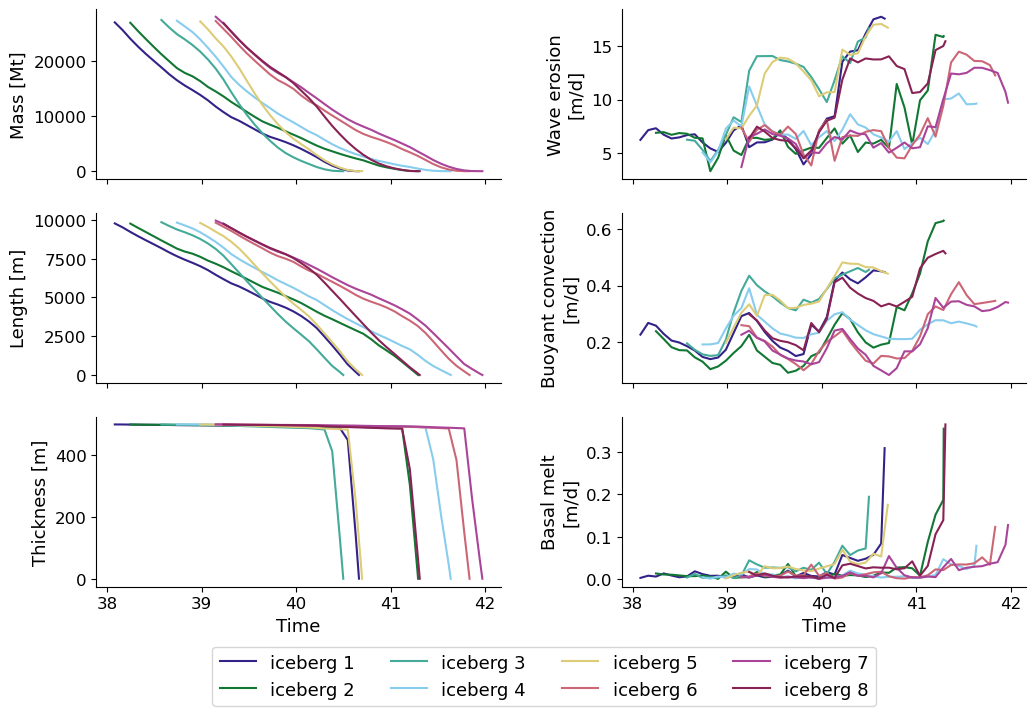

In [45]:
### Plot figure
fig = plt.figure(figsize=(12,7.5))
gs = fig.add_gridspec(3, 2, wspace=0.3, width_ratios=(1, 1))
axs = gs.subplots()

print(f'Start plotting...')
axs[0,0].set_prop_cycle(custom_cycler)
axs[0,0].plot(part['time'].T, part['M'].T*1e-9)
axs[0,0].set_ylabel('Mass [Mt]', fontsize=13)
axs[0,0].set_xticks(xticks)
axs[0,0].set_xticklabels([])
axs[0,0].spines['top'].set_visible(False)
axs[0,0].spines['right'].set_visible(False)
axs[0,0].tick_params(axis='y', which='both', labelsize=12)

axs[1,0].set_prop_cycle(custom_cycler)
axs[1,0].plot(part['time'].T, L.T)
axs[1,0].set_ylabel('Length [m]', fontsize=13)
axs[1,0].set_xticks(xticks)
axs[1,0].set_xticklabels([])
axs[1,0].spines['top'].set_visible(False)
axs[1,0].spines['right'].set_visible(False)
axs[1,0].tick_params(axis='y', which='both', labelsize=12)

axs[2,0].set_prop_cycle(custom_cycler)
axs[2,0].plot(part['time'].T, T.T)
axs[2,0].set_ylabel('Thickness [m]', fontsize=13)
axs[2,0].set_xlabel('Time', fontsize=13)
axs[2,0].set_xticks(xticks)
axs[2,0].set_xticklabels(labs, fontsize=12)
axs[2,0].spines['top'].set_visible(False)
axs[2,0].spines['right'].set_visible(False)
axs[2,0].tick_params(axis='y', which='both', labelsize=12)

print(f'   second column...')


axs[0,1].set_prop_cycle(custom_cycler)
axs[0,1].plot(part['time'].T, part['Mer'].T*86400.)
axs[0,1].set_ylabel('Wave erosion\n[m/d]', fontsize=13)
axs[0,1].set_xticks(xticks)
axs[0,1].set_xticklabels([])
axs[0,1].spines['top'].set_visible(False)
axs[0,1].spines['right'].set_visible(False)
axs[0,1].tick_params(axis='y', which='both', labelsize=12)

axs[1,1].set_prop_cycle(custom_cycler)
axs[1,1].plot(part['time'].T, part['Mvr'].T*86400.)
axs[1,1].set_ylabel('Buoyant convection\n[m/d]', fontsize=13)
axs[1,1].set_xticks(xticks)
axs[1,1].set_xticklabels([])
axs[1,1].spines['top'].set_visible(False)
axs[1,1].spines['right'].set_visible(False)
axs[1,1].tick_params(axis='y', which='both', labelsize=12)

axs[2,1].set_prop_cycle(custom_cycler)
axs[2,1].plot(part['time'].T, part['Mbr'].T*86400.)
axs[2,1].set_ylabel('Basal melt\n[m/d]', fontsize=13)
axs[2,1].set_xlabel('Time', fontsize=13)
axs[2,1].set_xticks(xticks)
axs[2,1].set_xticklabels(labs, fontsize=12)
axs[2,1].spines['top'].set_visible(False)
axs[2,1].spines['right'].set_visible(False)
axs[2,1].tick_params(axis='y', which='both', labelsize=12)

axs[2,1].legend(['iceberg 1', 'iceberg 2', 'iceberg 3', 'iceberg 4', 'iceberg 5', 'iceberg 6', 'iceberg 7', 'iceberg 8'], ncol=4,
               loc='upper right', bbox_to_anchor=(.65, -.30), fontsize=13)


print(f'   saving...')
plt.savefig(f'figures/Paper/FS03SFMeltrates.pdf', bbox_inches='tight', dpi=300)

plt.show()

Now, repeat the same for iceberg size class C4 from the main simulations (depth-integrated with iceberg grounding).

Supplements: Figure S4.4

In [46]:
### Load data
part, T, L = select_traj(C4g)
name = 'C4g'
label = 'C4 icebergs'

In [47]:
### Set axis properties
labs = ['38', '39', '40', '41', '42', '43']
ticks_list = [np.datetime64('2038-01-01'), np.datetime64('2039-01-01'), np.datetime64('2040-01-01'),
              np.datetime64('2041-01-01'), np.datetime64('2042-01-01'), np.datetime64('2043-01-01')]
xticks = (ticks_list - np.datetime64('1970-01-01')) / np.timedelta64(1, 'D')

Start plotting...
   second column...
   saving...


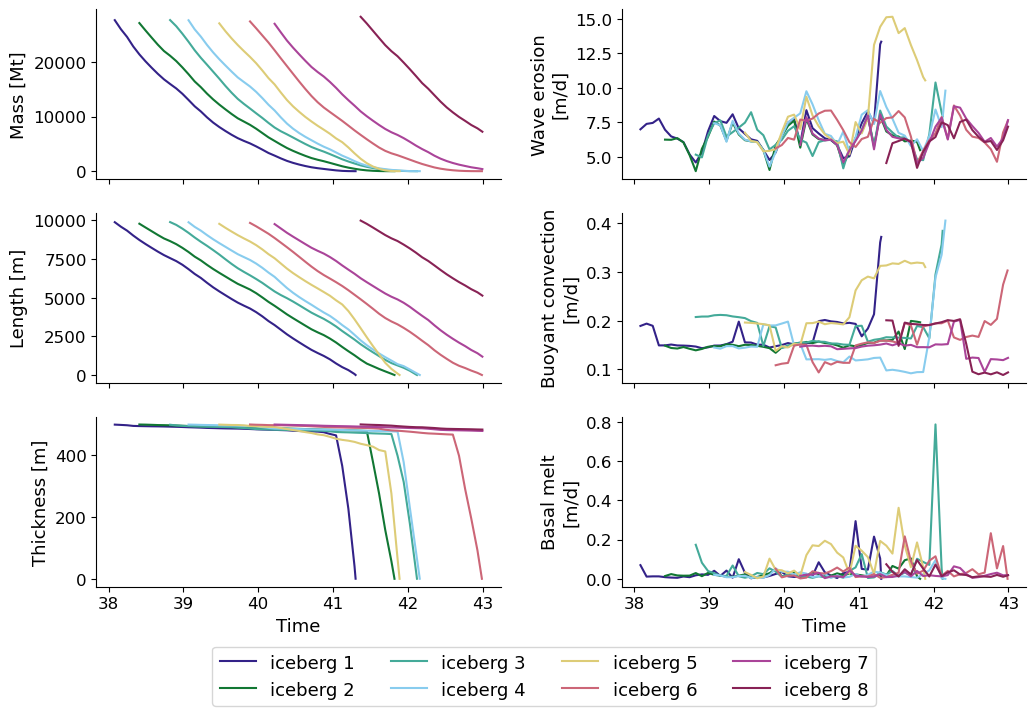

In [48]:
### Plot figure
fig = plt.figure(figsize=(12,7.5))
gs = fig.add_gridspec(3, 2, wspace=0.3, width_ratios=(1, 1))
axs = gs.subplots()

print(f'Start plotting...')
axs[0,0].set_prop_cycle(custom_cycler)
axs[0,0].plot(part['time'].T, part['M'].T*1e-9)
axs[0,0].set_ylabel('Mass [Mt]', fontsize=13)
axs[0,0].set_xticks(xticks)
axs[0,0].set_xticklabels([])
axs[0,0].spines['top'].set_visible(False)
axs[0,0].spines['right'].set_visible(False)
axs[0,0].tick_params(axis='y', which='both', labelsize=12)

axs[1,0].set_prop_cycle(custom_cycler)
axs[1,0].plot(part['time'].T, L.T)
axs[1,0].set_ylabel('Length [m]', fontsize=13)
axs[1,0].set_xticks(xticks)
axs[1,0].set_xticklabels([])
axs[1,0].spines['top'].set_visible(False)
axs[1,0].spines['right'].set_visible(False)
axs[1,0].tick_params(axis='y', which='both', labelsize=12)

axs[2,0].set_prop_cycle(custom_cycler)
axs[2,0].plot(part['time'].T, T.T)
axs[2,0].set_ylabel('Thickness [m]', fontsize=13)
axs[2,0].set_xlabel('Time', fontsize=13)
axs[2,0].set_xticks(xticks)
axs[2,0].set_xticklabels(labs, fontsize=12)
axs[2,0].spines['top'].set_visible(False)
axs[2,0].spines['right'].set_visible(False)
axs[2,0].tick_params(axis='y', which='both', labelsize=12)

print(f'   second column...')

axs[0,1].set_prop_cycle(custom_cycler)
axs[0,1].plot(part['time'].T, part['Mer'].T*86400.)
axs[0,1].set_ylabel('Wave erosion\n[m/d]', fontsize=13)
axs[0,1].set_xticks(xticks)
axs[0,1].set_xticklabels([])
axs[0,1].spines['top'].set_visible(False)
axs[0,1].spines['right'].set_visible(False)
axs[0,1].tick_params(axis='y', which='both', labelsize=12)

axs[1,1].set_prop_cycle(custom_cycler)
axs[1,1].plot(part['time'].T, part['Mvr'].T*86400.)
axs[1,1].set_ylabel('Buoyant convection\n[m/d]', fontsize=13)
axs[1,1].set_xticks(xticks)
axs[1,1].set_xticklabels([])
axs[1,1].spines['top'].set_visible(False)
axs[1,1].spines['right'].set_visible(False)
axs[1,1].tick_params(axis='y', which='both', labelsize=12)

axs[2,1].set_prop_cycle(custom_cycler)
axs[2,1].plot(part['time'].T, part['Mbr'].T*86400.)
axs[2,1].set_ylabel('Basal melt\n[m/d]', fontsize=13)
axs[2,1].set_xlabel('Time', fontsize=13)
axs[2,1].set_xticks(xticks)
axs[2,1].set_xticklabels(labs, fontsize=12)
axs[2,1].spines['top'].set_visible(False)
axs[2,1].spines['right'].set_visible(False)
axs[2,1].tick_params(axis='y', which='both', labelsize=12)

axs[2,1].legend(['iceberg 1', 'iceberg 2', 'iceberg 3', 'iceberg 4', 'iceberg 5', 'iceberg 6', 'iceberg 7', 'iceberg 8'], ncol=4,
               loc='upper right', bbox_to_anchor=(.65, -.30), fontsize=13)


print(f'   saving...')
plt.savefig(f'figures/Paper/FS04C4gMeltrates.pdf', bbox_inches='tight', dpi=300)

plt.show()